In [113]:

from keras.utils import to_categorical
from keras.optimizers import Adam, Adadelta
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
from scipy import signal
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [21]:
# constants:
SUBSAMPLE = 100  # scales the data by this factor can be replaced by divding the steps per epoch by batch size
COLUMNS = ['HandStart', 'FirstDigitTouch',
        'BothStartLoadPhase', 'LiftOff',
        'Replace', 'BothReleased']
SUBJECTS = range(1, 2)
N_LABELS = 6

# Below are the paths to the data. Please pay attention to the % and * signs, these are needed in the loop.
TRAIN_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/train/subj%d_series*_data.csv'
#The path below is for the test data used for a kaggle submission. This is not very relevant to our project.
# TEST_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/test/subj%d_series*_data.csv'
# TRAIN_DATA_PATH = 'C:/Users/bas/Documents/MachineLearning/train/subj%d_series*_data.csv' #path on my laptop
# TEST_DATA_PATH =  'C:/Users/bas/Documents/MachineLearning/test/subj%d_series*_data.csv' 

SUBMISSION_FOLDER = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/'
SUBMISSION_NAME = 'subbmision_vu_48_sub_pca_4.csv'

PCA_COMPONENTS = 0.8
CUTT_OFF_FREQUENCY = 2
ORDER = 4
SAMPLE_FREQUENCY = 500

EPOCHS = 5
WINDOW_SIZE = 500

In [22]:
def prepare_training_data(data_path):
    data = pd.read_csv(data_path)
    event_path = data_path.replace('_data', '_events')
    labels = pd.read_csv(event_path)
    clean_data = data.drop(['id'], axis = 1)
    labels = labels.drop(['id'], axis = 1)
    return clean_data, labels

In [23]:
def prepare_test_data(data_path):
    data = pd.read_csv(data_path)
    return data

In [24]:
def scaler_transform(data, scaler):
    if scaler == None:
        scaler = StandardScaler()
        return scaler.fit_transform(data), scaler
    else:
        return scaler.transform(data)        

In [25]:
def read_training_data(train_data_paths):
    labels_raw = []
    features_raw = []
    for data_path in train_data_paths:
        data, labels = prepare_training_data(data_path)
        features_raw.append(data)
        labels_raw.append(labels)
    features_raw = pd.concat(features_raw)
    labels_raw = pd.concat(labels_raw)
    x_train = np.asarray(features_raw.astype(float))
    y_train = np.asarray(labels_raw.astype(float))
    return x_train, y_train

In [26]:
def read_test_data(test_data_paths):
    test_features_raw = []
    ids = []
    for data_path in test_data_paths:
        data = prepare_test_data(data_path)
        test_features_raw.append(data)
        ids.append(np.array(data['id']))
    test_features_raw = pd.concat(test_features_raw)
    ids = np.concatenate(ids)
    test_features_raw = test_features_raw.drop(['id'], axis = 1)
    x_test = np.asarray(test_features_raw.astype(float))
    return x_test, ids

In [27]:
def metric_auc_score(predictions, y_test, with_plot):
    scores = []
    legend_text = []
    for i in range(N_LABELS):
        fpr, tpr, _  = roc_curve(y_test[:,i], predictions[:,i], 1)
        scores.append(roc_auc_score(y_test[:,i], predictions[:,i]))
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (scores[i]))
        if with_plot == True:
            plt.plot(fpr, tpr)
    if with_plot == True:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
        plt.show()
    return scores

In [28]:
def single_metric_auc_score(predictions, y_test, with_plot):
    fpr, tpr, _  = roc_curve(y_test, predictions, 1)
    score = roc_auc_score(y_test, predictions)
    print(COLUMNS[0]+' AUC score = %.3f' % (score))
    if with_plot == True:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.show()
    return score

In [29]:
def all_auc_scores(prediction_total, test_data_total, subjects, with_plot):
    scores = []
    for subject in subjects:
        score = metric_auc_score(prediction_total[subject-1],
                                 test_data_total[subject-1], with_plot)
        scores.append(score)
        print('Mean AUC Score of Subject %d: %.3f' % \
              (subject, np.mean(score)))
    return scores

In [125]:
# def image_mappping(x_train, WINDOW_SIZE):
#     result = []
#     empty_matrix = np.atleast_3d(np.zeros(np.shape(x_train[0:WINDOW_SIZE])))
#     for i in range(len(x_train)):
#         if i-WINDOW_SIZE < 0:
#             result.append(empty_matrix)
#         else:
#             result.append(np.atleast_3d(x_train[i-WINDOW_SIZE:i]))
#     return result

def image_mappping(x_train, WINDOW_SIZE):
    result = []
    empty_matrix = np.zeros(np.shape(x_train[0:WINDOW_SIZE]))
    for i in range(len(x_train)):
        if i-WINDOW_SIZE < 0:
            result.append(empty_matrix)
        else:
            result.append(x_train[i-WINDOW_SIZE:i])
    return result

In [123]:
def train_generator(x_train, y_train, WINDOW_SIZE):
    x = image_mappping(x_train, WINDOW_SIZE)
    while True:
        for image, task in zip(x, y_train):
            yield np.array([image]), np.array([task])

In [32]:
def test_generator(x_test, WINDOW_SIZE):
    x = image_mappping(x_test, WINDOW_SIZE)
    while True:
        for image in x:
            yield np.array([image])

In [ ]:
def class_weights(y_train):
    class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train[:,0]), y_train[:,0])
    return {0 : class_weight[1], 2: class_weight[0]}

In [143]:
def init_cnn(window):
    model = Sequential((
    # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
    # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
    # the input timeseries, the activation of each filter at that position.
    Conv1D(nb_filter=50, filter_length=250, activation='relu', input_shape=(window, 32)),
    MaxPooling1D(),     # Downsample the output of convolution by 2X.
    Conv1D(nb_filter=50, filter_length=100, activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(2, activation='softmax'),    
    ))
    optimizer = Adadelta()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    
#     model = Sequential()
#     model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(window,32,1)))
#     model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(MaxPool2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25)) # Dropout 25% of the nodes of the previous layer during training
#     model.add(Flatten())     # Flatten, and add a fully connected layer
#     model.add(Dense(128, activation='relu')) 
#     model.add(Dropout(0.5))
#     model.add(Dense(2, activation='softmax')) # Last layer: 10 class nodes, with dropout
#     model.summary()
    optimizer = Adadelta()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [147]:
for subject in SUBJECTS:
    test_features_raw = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))
  
    x_train, y_train = read_training_data(train_data_paths)  
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.5)
    
    x_train, scaler = scaler_transform(x_train, None)
    x_test = scaler_transform(x_test, scaler)
    
    train_labels = to_categorical(y_train[:,0], num_classes = None)
    test_labels = to_categorical(y_test[:,0], num_classes = None)

    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train[:,0]), y_train[:,0])
    class_weights = {0 : 1., 1: class_weights[1], 2: class_weights[0]}
    
    


In [148]:
model = init_cnn(window=WINDOW_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 251, 50)           400050    
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 125, 50)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 26, 50)            250050    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 13, 50)            0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 650)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 1302      
Total params: 651,402
Trainable params: 651,402
Non-trainable params: 0
_________________________________________________________________


In [149]:
my_generater = train_generator(x_train, train_labels, WINDOW_SIZE)
my_test_generater = train_generator(x_test, test_labels, WINDOW_SIZE)
model.fit_generator(my_generater, steps_per_epoch=len(x_train)/100, epochs=2, 
                    class_weight=class_weights, verbose=1, 
                    validation_data=my_test_generater, 
                    validation_steps = len(x_test)/100)

Epoch 1/2
7112/7111 [==============================] - 137s 19ms/step - loss: 8.0873 - acc: 0.8783 - val_loss: 0.4766 - val_acc: 0.9698
Epoch 2/2
7112/7111 [==============================] - 124s 18ms/step - loss: 7.9129 - acc: 0.9730 - val_loss: 0.4621 - val_acc: 0.9712


In [150]:
my_test_generater = test_generator(x_test, WINDOW_SIZE)
predictions = model.predict_generator(my_test_generater, steps=len(x_test)/100)

HandStart AUC score = 0.493


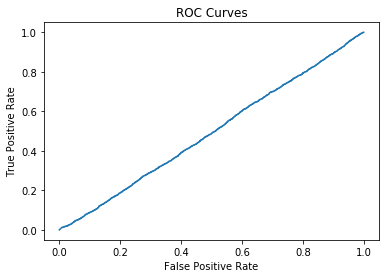

AUC score: 0.493


In [151]:
score = single_metric_auc_score(predictions[:, 1], test_labels[:,1][::100], True)
print('AUC score: %.3f' % (score))

In [98]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

7112